# Contour length index (CLI)

In [1]:
from IPython.display import HTML

%run ../_setup.py

import numpy as np
import datetime

from netCDF4 import Dataset, num2date

from OceanPy.animations import play2D

import matplotlib.pyplot as plt

In [2]:
input_file = os.path.join(datadir, 'external', 'ssh', 'SEALEVEL_GLO_PHY_L4_REP_OBS_137_-52.4_147_-48_199801-199812.nc')
sl = Dataset(input_file)
# sl.variables.keys()

lon, lat = sl['longitude'][:], sl['latitude'][:]

In [7]:
annualmean = np.mean(sl['adt'], axis=0)

def contour_length(lon, lat, var, contour_range=(-0.1, 0.4)): #contour_center= , 
    
    contour_center = (contour_range[1] - contour_range[0]) / 2
            
    lat_ct = []
    cl = 0
    
    # for each longitudinal grid cell from west to east
    for iln in range(len(lon)):
        
        # find latitudinal indices within contour range
        ilt = np.where((var[:, iln] < contour_range[1]) & (var[:, iln] > contour_range[0]))[0]

        # find latitudinal index of center contour, but not further than one latitudinal step away from previous
#         iltc = (np.abs(var[:,iln] - contour_center)).argmin()
#         iltc = np.argsort(np.abs(var[:, iln] - contour_center))
        if iln > 0:
            iltc = (iltc-2) + (np.abs(var[iltc-2:iltc+2,iln] - contour_center)).argmin()           
        else:
            iltc = (np.abs(var[:,iln] - contour_center)).argmin()
        
        # determine mean latitude in contour range
        lats = lat[ilt]
        if len(ilt) > 1:
            print(np.where(ilt == iltc))
            ic = np.where(ilt == iltc)[0][0]
            trueidx = np.zeros(len(ilt), dtype=bool)
            trueidx[ic] = True
            
            # find latitudinal indices that are consecutive/ contiguous from center contour
            contiguous = iltc
            for i in range(ic+1, len(ilt)):
                if ilt[i] == contiguous + 1: #and not ilt[i] > iltc + 3:
                    trueidx[i] = True
                contiguous += 1
            contiguous = iltc
            for i in reversed(range(0, ic)):
                if ilt[i] == contiguous - 1: #and not ilt[i] < iltc - 3:
                    trueidx[i] = True
                contiguous -= 1
                        
            lat_mean = np.mean(lats[trueidx])
          
        elif len(ilt) == 1:
            lat_mean = lat[iltc]
        
        lat_ct.append(lat_mean)
     
#         # find latitude for prescribed contour value
#         ilt = (np.abs(var[:,iln] - contour)).argmin()
#         lat_ct.append(lat[ilts])

        # calculate latitudinal and longitudinal increments and calculate contour length
        if iln > 0:
            dlon = lon[iln] - lon[iln-1]
            dlat = lat_ct[iln] - lat_ct[iln-1]
            
#             print(dlon, dlat)

            cl += np.sqrt(dlon*2 + dlat**2)
        
    return cl, lat_ct

cl, lat_ct = contour_length(lon, lat, annualmean, contour_range=(-0.1, 0.4))

# annualmean = np.mean(sl['adt'][60:80], axis=0)

(array([6]),)
(array([6]),)
(array([6]),)
(array([6]),)
(array([5]),)
(array([5]),)
(array([4]),)
(array([4]),)
(array([4]),)
(array([4]),)
(array([4]),)
(array([4]),)
(array([3]),)
(array([3]),)
(array([3]),)
(array([3]),)
(array([3]),)
(array([2]),)
(array([2]),)
(array([3]),)
(array([3]),)
(array([2]),)
(array([2]),)
(array([2]),)
(array([2]),)
(array([2]),)
(array([3]),)
(array([4]),)
(array([4]),)
(array([5]),)
(array([4]),)
(array([4]),)
(array([4]),)
(array([5]),)
(array([5]),)
(array([6]),)
(array([7]),)
(array([7]),)
(array([8]),)
(array([6]),)
(array([5]),)


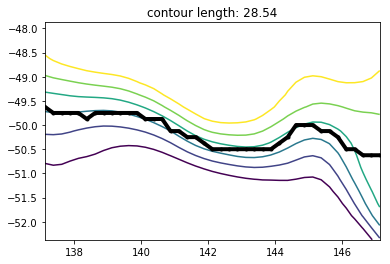

In [4]:
plt.contour(sl['longitude'][:], sl['latitude'][:], annualmean, [-0.1, 0, 0.1, 0.2, 0.3, 0.4])
plt.plot(lon, lat_ct, 'k.-', linewidth=4, )
plt.title('contour length: %s' %round(cl, 2))

In [5]:
# determine time of the voyage
time = sl['time']
time = num2date(time[:], time.units)
begin = datetime.datetime(1998, 3, 10)
end = datetime.datetime(1998, 3, 28)

timevoy = np.array([begin <= t <= end for t in time])

##### fig, ax = plt.subplots(3, 4, figsize=(16, 8), sharex=True, sharey=True)
rows, cols = ax.shape
month = 1

cli = []
for row in range(rows):
    for col in range(cols):
        idx = [t.month == month for t in time]

        monthlymean = np.mean(sl['adt'][idx,], axis=0)
        cl, lat_ct = contour_length(lon[4:32], lat, monthlymean[:, 4:32], contour_range=(0, 0.3))
        cli.append(cl)
        ct = ax[row, col].contour(sl['longitude'][:], sl['latitude'][:], monthlymean, np.linspace(-0.1, 0.4, 5)) #[-0.1, 0, 0.1, 0.2, 0.3, 0.4]
        ax[row, col].contour(sl['longitude'][:], sl['latitude'][:], monthlymean, [0.15], colors='r', linewidths=2)
        ax[row, col].plot(lon[4:32], lat_ct, 'k.-', linewidth=2, markersize=5)
        ax[row, col].set_title('%s, contour length: %s' %(month, round(cl, 2)))
        ax[row, col].axvline(138, color='k')
        ax[row, col].axvline(145, color='k')

        month += 1

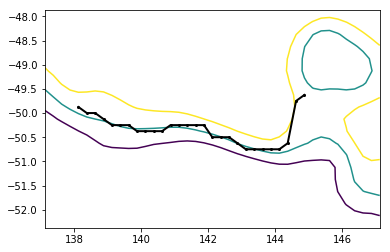

In [7]:
month=12
idx = [t.month == month for t in time]
monthlymean = np.mean(sl['adt'][idx,], axis=0)
cl, lat_ct = contour_length(lon[4:32], lat, monthlymean[:, 4:32], contour_range=(0.0,0.3))

fig, ax = plt.subplots()
ct = ax.contour(sl['longitude'][:], sl['latitude'][:], monthlymean, [0, 0.15, 0.3])
ax.plot(lon[4:32], lat_ct, 'k.-', linewidth=2, markersize=4)


In [8]:
sl.variables.keys()

odict_keys(['err', 'time', 'latitude', 'longitude', 'vgosa', 'vgos', 'sla', 'ugosa', 'adt', 'ugos'])

In [9]:
sl['sla']

<class 'netCDF4._netCDF4.Variable'>
int32 sla(time, latitude, longitude)
    _FillValue: -2147483647
    comment: The sea level anomaly is the sea surface height above mean sea surface; it is referenced to the [1993, 2012] period; see the product user manual for details
    coordinates: time latitude longitude 
    grid_mapping: crs
    long_name: Sea level anomaly
    scale_factor: 0.0001
    standard_name: sea_surface_height_above_sea_level
    units: m
unlimited dimensions: 
current shape = (365, 19, 41)
filling off

In [10]:
import pandas as pd
pd.date_range(start='1/1/1998', periods=12, freq='M')

df = pd.read_csv(os.path.join(datadir, 'external', 'sam', 'monthly_sam_1957-2007.txt'), sep='\s+')
df.columns = range(1, 13)
df = df.stack()
year = df.index.get_level_values(0).values
month = df.index.get_level_values(1).values

df.index = pd.PeriodIndex(year=year, month=month, freq='M')
df98 = pd.DataFrame(df.loc[df.index.year == 1998], columns=['SAM'])
df98['CLI'] = cli
df98



,SAM,CLI
1998-01,2.65,19.276341
1998-02,0.57,19.395019
1998-03,-0.05,19.469841
1998-04,2.89,19.326732
1998-05,1.11,19.392367
1998-06,1.31,19.329237
1998-07,2.13,19.276341
1998-08,2.66,19.308271
1998-09,0.74,19.470802
1998-10,-0.26,20.052300
